# Tune-up Template 

## 0. Chip Layout, Wiring, and Fabrication 

### 0.1 Chip layout

Put your chip layout here

### 0.2 Wiring

Describe your wiring here

### 0.3 Fabrication Parameters

You might know something about your qubits from fabrication, you can put those here before you start:

|                  | QB1               | QB2          | QB3               | QB4               | QB5          | QB6               |
|------------------|-------------------|--------------|-------------------|-------------------|--------------|-------------------|
| Upper Sweet Spot |  |  |  |  |  |  |
| Lower Sweet Spot |  |  |  |  |  |  |
| Resonator        | 7.0G              | 7.2G         | 7.4G              | 7.1G              | 7.3G         | 7.5G              |

## 1. Imports


# Tune-up Template 

## 0. Chip Layout, Wiring, and Fabrication 

### 0.1 Chip layout

Put your chip layout here

### 0.2 Wiring

Describe your wiring here

### 0.3 Fabrication Parameters

You might know something about your qubits from fabrication, you can put those here before you start:

|                  | QB1               | QB2          | QB3               | QB4               | QB5          | QB6               |
|------------------|-------------------|--------------|-------------------|-------------------|--------------|-------------------|
| Upper Sweet Spot |  |  |  |  |  |  |
| Lower Sweet Spot |  |  |  |  |  |  |
| Resonator        | 7.0G              | 7.2G         | 7.4G              | 7.1G              | 7.3G         | 7.5G              |

## 1. Imports


In [1]:
# convenience Import for all LabOne Q Functionality
from laboneq.simple import *

# plotting and fitting functionality
from laboneq.contrib.example_helpers.data_analysis.data_analysis import (
    func_invLorentz,
    func_osc,
    fit_Spec,
    fit_Rabi,
    func_decayOsc,
    fit_Ramsey,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import (
    plot_simulation,
    plot_results,
)

# descriptor imports
from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor

# for saving results and pulse sheets
from pathlib import Path
import datetime
import time
import scipy
import json
import yaml
from ruamel.yaml import YAML

import matplotlib.pyplot as plt
import numpy as np

from helpers.tuneup_helper import (
    flatten,
    rotate_to_real_axis,
    calc_readout_weight,
    evaluate_rabi,
    evaluate_ramsey,
    evaluate_T1,
    analyze_ACStark,
    analyze_qspec,
    create_x180,
    create_x180_ef,
    create_x90,
    create_x90_ef,
    update_qubit_parameters_and_calibration,
    load_qubit_parameters,
    create_transmon,
    save_results,
    plot_with_trace_rabi,
    calculate_fidelity
)

from helpers.experiment_library import (
    resonator_spectroscopy_parallel_CW_full_range,
    resonator_spectroscopy_single,
    resonator_spectroscopy_g_vs_e,
    readout_pulse,
    integration_kernel,
    pulsed_resonator_spectroscopy_single,
    qubit_spectroscopy_parallel,
    qubit_spectroscopy_single,
    res_spectroscopy_pulsed_amp_sweep,
    amplitude_rabi_parallel,
    amplitude_rabi_single,
    ramsey_parallel,
    t1_parallel,
    ecr_amplitude_sweep,
    create_freq_sweep,
    qubit_drive_pulse,
    create_amp_sweep,
    readout_gauss_square_pulse,
    qubit_gaussian_pulse,
)

import logging

from helpers.experiment_library import qubit_spectroscopy_single

In [2]:
from cycler import cycler
plt.rcParams.update({
    'font.family': 'ZI Akkurat',
    'font.weight': 'light',
    'axes.labelweight': 'light',
    'axes.titleweight': 'normal',
    'svg.fonttype': 'none', #Make text editable in SVG
    'text.usetex': False
})

In [3]:
blue_color_zi = '#009EE0'
orange_color_zi = '#EE7F00'
dark_blue_color_zi = '#172983'

## 2. Set-up


### Emulation Mode


In [4]:
emulate = False

### Database Set-up


In [5]:
# set up connection to database
demo_setup_db = DataStore("laboneq_data/setup_database.db")

demo_results_db = DataStore("laboneq_data/results_database.db")

# # check if data is already stored in database
# for key in demo_setup_db.keys():
#     print(key)

### Device Set-up


In [6]:
from textwrap import dedent

descriptor = dedent(
    """\
instruments:
  SHFQC:
    - address: dev12250
      uid: device_shfqc
connections:

  device_shfqc:
    - iq_signal: q0/measure_line
      ports: QACHANNELS/0/OUTPUT
    - acquire_signal: q0/acquire_line
      ports: QACHANNELS/0/INPUT
      
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/3/OUTPUT
"""
)
demo_setup = DeviceSetup.from_descriptor(
    descriptor, server_host="localhost", server_port=8004, setup_name="MySetup"
)

### Apply Calibration from File


In [7]:
qubit_parameters = load_qubit_parameters()

qubit_parameters["local_oscillators"]["readout_lo"]["value"] = 7.0e9

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)
print(demo_setup.get_calibration())

Calibration(
│   calibration_items={
│   │   '/logical_signal_groups/q0/drive_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_drive_ge_osc',
│   │   │   │   frequency=748945327.5086765,
│   │   │   │   modulation_type=ModulationType.HARDWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_drive_local_osc',
│   │   │   │   frequency=5000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=10,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/logical_signal_groups/q0/measure_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_measure_osc',
│   │   │   │   frequency=260000000.0,
│   │   │   │   modulation_type=ModulationType.SOFTWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-25,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/logical_signal_groups/q0/acquire_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_acquire_osc',
│   │   │   │   frequency=260000000.0,
│   │   │   │   modulation_type=ModulationType.SOFTWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=2.4e-07,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-5,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/qachannels_0_output': SignalCalibration(
│   │   │   oscillator=None,
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-25,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/qachannels_0_input': SignalCalibration(
│   │   │   oscillator=None,
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=2.4e-07,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-5,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/sgchannels_3_output': SignalCalibrat

### Create and Connect to a QCCS Session 

Establishes the connection to the instruments and readies them for experiments


In [8]:
# create and connect to a session 
session = Session(device_setup=demo_setup)
session.connect(do_emulation=emulate, reset_devices=True)

2023.09.29 16:22:39.558 laboneq.controller.laboneq_logging INFO   Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is c:\Users\ZI_at_PSI\code\Tune_up_scripts\laboneq_output\log
2023.09.29 16:22:39.560 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.29 16:22:39.561 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.29 16:22:39.617 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.29 16:22:41.140 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.29 16:22:41.336 laboneq.controller.devices.device_collection INFO   The device setup is configured


## CW Spectroscopy


In [9]:
cw_spectroscopy_exp = resonator_spectroscopy_parallel_CW_full_range(
    transmon_list,
    create_freq_sweep("outer", 6e9, 8e9, 3),
    create_freq_sweep("inner", -500e6, 500e6, 1001),
)
session.connect(do_emulation=False, reset_devices=True)
compiled_cw_spectroscopy_exp = session.compile(cw_spectroscopy_exp)
cw_spectroscopy_results = session.run(compiled_cw_spectroscopy_exp)

2023.09.29 16:22:41.486 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.29 16:22:41.486 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.29 16:22:41.493 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.29 16:22:42.871 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.29 16:22:43.010 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.29 16:22:43.248 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.29 16:22:43.324 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.29 16:22:43.556 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 25
2023.09.29 16:22:43.557 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 0
2023.09.29 16:22:43.557 laboneq.compiler.workflow.co

Text(0.5, 1.0, 'CW resonator spectroscopy, large range')

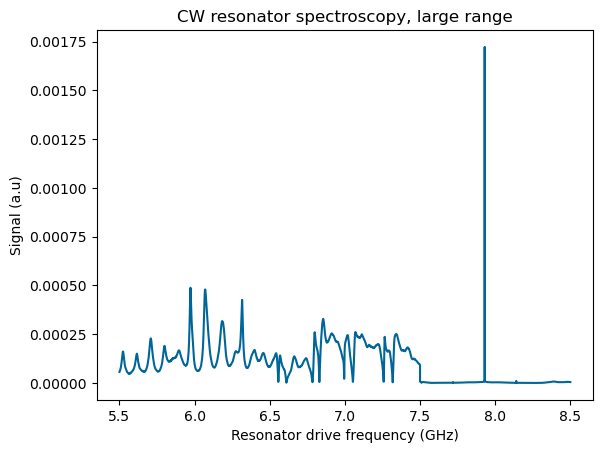

In [10]:
# access and plot results of one 8GHz sweep
gnd_signal = abs(cw_spectroscopy_results.get_data("resonator_spectroscopy_q0"))

outer = cw_spectroscopy_results.get_axis("resonator_spectroscopy_q0")[0]
inner = cw_spectroscopy_results.get_axis("resonator_spectroscopy_q0")[1]
full_sweep = np.array(flatten([out + inner for out in outer]))

plt.plot(full_sweep/1e9, np.array(flatten([data for data in gnd_signal])))
plt.xlabel("Resonator drive frequency (GHz)")
plt.ylabel("Signal (a.u)")
plt.title("CW resonator spectroscopy, large range")

In [11]:
save_results(demo_results_db, cw_spectroscopy_results, "cw_spec_results", "full_sweep")

# Baseband sweep CW spectroscopy

In [12]:
single_cw = resonator_spectroscopy_single(
    transmon_list[0],
    create_freq_sweep(f"{transmon_list[0].uid}_sweep", 210e6, 290e6, 401),
    measure_range=-25,
    acquire_range=-5,
)
session.connect(do_emulation=emulate, reset_devices=True)
compiled_single_cw_spect_exp = session.compile(single_cw)
cw_spectroscopy_results = session.run(compiled_single_cw_spect_exp)
#plot_results(cw_spectroscopy_results)

2023.09.29 16:23:26.339 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.29 16:23:26.340 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.29 16:23:26.346 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.29 16:23:27.720 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.29 16:23:27.863 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.29 16:23:28.107 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.29 16:23:28.140 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.29 16:23:28.307 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 25
2023.09.29 16:23:28.308 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 0
2023.09.29 16:23:28.309 laboneq.compiler.workflow.co

### Make nice resonator spectroscopy plot

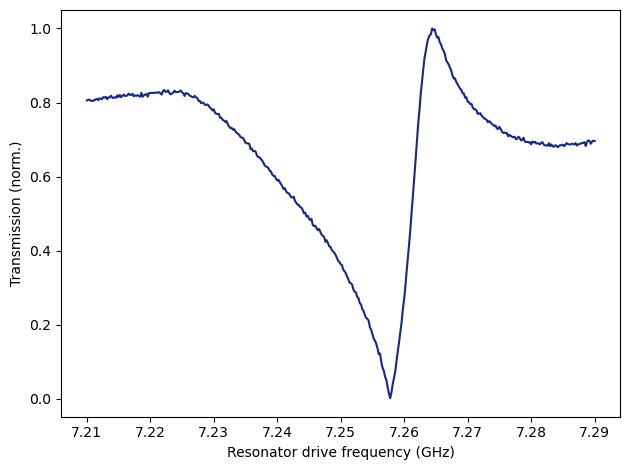

In [13]:
lo_frequency = cw_spectroscopy_results.experiment.signals["measure_q0"].calibration.local_oscillator.frequency

gnd_signal = abs(cw_spectroscopy_results.get_data("resonator_spectroscopy_q0"))
full_sweep = cw_spectroscopy_results.get_axis("resonator_spectroscopy_q0")[0] + lo_frequency

gnd_signal = gnd_signal/max(gnd_signal)

plt.plot(full_sweep/1e9, gnd_signal, color = dark_blue_color_zi)
plt.xlabel("Resonator drive frequency (GHz)")
plt.ylabel("Transmission (norm.)")
plt.tight_layout()

In [14]:
#analyze_qspec(res=cw_spectroscopy_results, handle="resonator_spectroscopy_q0")

In [12]:
first_readout_res = lo_frequency + 0.258e9
print(first_readout_res)

7258000000.0


In [13]:
qubit_parameters["qubits"]["q0"]["readout_resonator_frequency"][
    "value"
] = first_readout_res

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

# Spectroscopy vs Power - "Punchout" NOT TESTED


2023.09.28 15:00:33.506 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.28 15:00:33.506 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.28 15:00:33.510 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.28 15:00:34.926 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.28 15:00:35.068 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.28 15:00:35.316 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.28 15:00:35.395 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.28 15:00:35.753 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 23
2023.09.28 15:00:35.754 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 3200
2023.09.28 15:00:35.754 laboneq.compiler.workflow

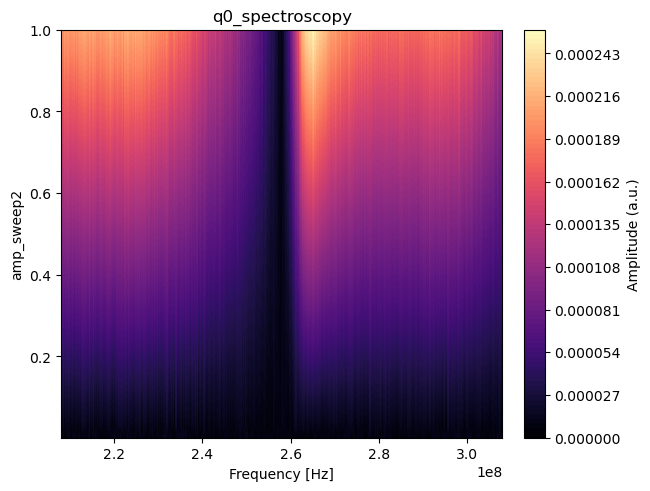

In [18]:
if True:
    freq_upper = (
        transmon_list[0].parameters.readout_resonator_frequency
        - transmon_list[0].parameters.readout_lo_frequency
        + 50e6
    )
    freq_lower = (
        transmon_list[0].parameters.readout_resonator_frequency
        - transmon_list[0].parameters.readout_lo_frequency
        - 50e6
    )

    amp_sweep = SweepParameter(
        uid="amp_sweep2",
        values=np.logspace(start=np.log10(0.001), stop=np.log10(1), num=3),
    )

    punchout = res_spectroscopy_pulsed_amp_sweep(
        qubit=transmon_list[0],
        integration_kernel=integration_kernel,
        readout_pulse=readout_gauss_square_pulse,
        frequency_sweep=create_freq_sweep(
            f"{transmon_list[0].uid}_sweep", freq_lower, freq_upper, 1001
        ),
        amplitude_sweep=amp_sweep,
        num_averages=2**8,
        measure_range=-25,
        acquire_range=-5,
    )

    session.connect(do_emulation=False, reset_devices=True)
    comp_punchout = session.compile(punchout)
    punchout_result = session.run(comp_punchout)

    plot_results(punchout_result)

In [ ]:
if False:
    save_results(
        demo_results_db,
        punchout_result,
        "punchout",
        "neg_25_meas_neg_5_acq_range",
    )

In [ ]:
if False:
    qubit_parameters["multiplex_readout"]["readout_amplitude"]["value"] = 0.55

    transmon_list = update_qubit_parameters_and_calibration(
        qubit_parameters, demo_setup, demo_setup_db
    )

## Continue with your tune-up experiments:

* Qubit Spec
* Rabi
* Ramsey
* T1
* Hahn Echo

What's after that? There are many ways to go once you have done the basics:

* Drag pulse tune-up
* Single shot readout
* Active reset
* f-level tune-up
* Two qubit gates
* Tomography
* RB

# Qubit Spectroscopy

In [15]:
def gen_const_pulse(qubit, length=15e-5,amplitude=1.0):
    return pulse_library.const(uid=f"{qubit}",length=length,amplitude=amplitude, can_compress=True)

In [16]:
qubit_parameters["qubits"]["q0"]["drive_range_ge"]["value"]=-30
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [17]:

qubit_spec_exp = qubit_spectroscopy_single(
    qubit = transmon_list[0],
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    qubit_spectroscopy_pulse=gen_const_pulse,
    qspec_range=6e6,
    qspec_num=251,
    num_averages=2**10,
)


In [18]:
session.connect(do_emulation=emulate,reset_devices=True)
qspec_res=session.run(qubit_spec_exp)

2023.09.29 16:23:37.619 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.29 16:23:37.620 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.29 16:23:37.625 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.29 16:23:39.058 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.29 16:23:39.201 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.29 16:23:39.465 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.29 16:23:39.503 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.29 16:23:41.682 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 46
2023.09.29 16:23:41.682 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 3264
2023.09.29 16:23:41.683 laboneq.compiler.workflow

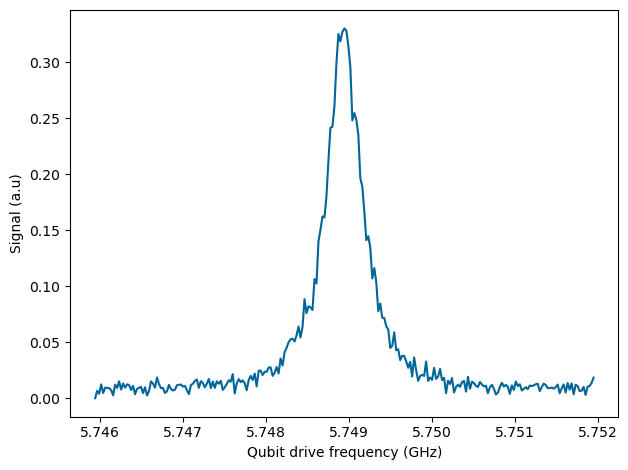

In [19]:
lo_frequency = qubit_parameters["qubits"]["q0"]["drive_lo_frequency"]["value"]

gnd_signal = abs(qspec_res.get_data("q0_spectroscopy") - qspec_res.get_data("q0_spectroscopy")[0])
gnd_signal = gnd_signal
#gnd_signal = abs(qspec_res.get_data("q0_spectroscopy"))
full_sweep = qspec_res.get_axis("q0_spectroscopy")[0] + lo_frequency

plt.plot(full_sweep/1e9, gnd_signal)
plt.xlabel("Qubit drive frequency (GHz)")
plt.ylabel("Signal (a.u)")
plt.tight_layout()

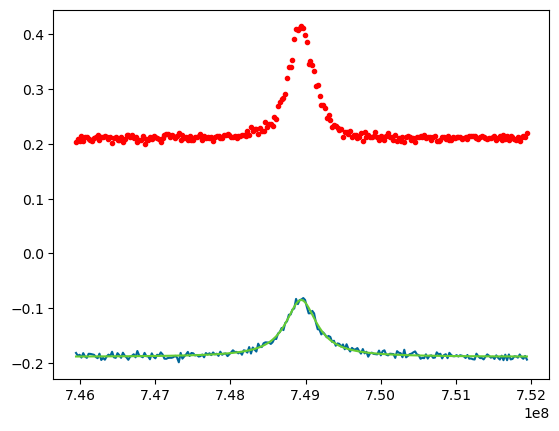

748941201.2756323


In [20]:
qubit_resonance=analyze_qspec(qspec_res,"q0_spectroscopy",f0=7.49e8,a=0.03,gamma=1E6, flip=True, rotate = True)
print(qubit_resonance)

### Update qubit resonance

In [21]:
qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"][
    "value"
] =  qubit_parameters["qubits"]["q0"]["drive_lo_frequency"][
    "value"
] + qubit_resonance
print(qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"]["value"])
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

5748941201.275632


# Amplitude Rabi

In [184]:
qubit_parameters["qubits"]["q0"]["drive_range_ge"]["value"]=10
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [185]:
def amplitude_rabi_single(
    qubit,
    drive_pulse,
    integration_kernel,
    readout_pulse,
    amplitude_sweep,
    num_averages=2**10,
    cal_trace=False,
    pi_amplitude=0.5,
):
    exp_rabi = Experiment(
        uid="Qubit Spectroscopy",
        signals=flatten(
            [
                [
                    ExperimentSignal(
                        f"drive_{qubit.uid}", map_to=qubit.signals["drive"]
                    ),
                    ExperimentSignal(
                        f"measure_{qubit.uid}", map_to=qubit.signals["measure"]
                    ),
                    ExperimentSignal(
                        f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]
                    ),
                ]
            ]
        ),
    )

    ## define Rabi experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_rabi.acquire_loop_rt(
        uid="rabi_shots",
        count=num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        # inner loop - real time sweep of Rabi amplitudes
        with exp_rabi.sweep(uid="rabi_sweep", parameter=amplitude_sweep):
                # qubit drive
                with exp_rabi.section(
                    uid=f"{qubit.uid}_excitation", alignment=SectionAlignment.RIGHT
                ):
                    exp_rabi.play(
                        signal=f"drive_{qubit.uid}",
                        pulse=drive_pulse(qubit, amplitude=1),
                        amplitude=amplitude_sweep,
                    )
                # measurement
                with exp_rabi.section(
                    uid=f"readout_{qubit.uid}", play_after=f"{qubit.uid}_excitation"
                ):
                    exp_rabi.measure(
                        measure_signal=f"measure_{qubit.uid}",
                        measure_pulse=readout_pulse(qubit),
                        handle=f"{qubit.uid}_rabi",
                        acquire_signal=f"acquire_{qubit.uid}",
                        integration_kernel=integration_kernel(qubit),
                        reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                    )
        if cal_trace:
            with exp_rabi.section(uid="cal_trace_gnd_meas"):
                exp_rabi.measure(
                    measure_signal=f"measure_{qubit.uid}",
                    measure_pulse=readout_pulse(qubit),
                    handle=f"{qubit.uid}_rabi_cal_trace",
                    acquire_signal=f"acquire_{qubit.uid}",
                    integration_kernel=integration_kernel(qubit),
                    reset_delay=1e-6, # qubit.parameters.user_defined["reset_delay_length"],
                )
            with exp_rabi.section(uid="cal_trace_exc", play_after="cal_trace_gnd_meas"):
                exp_rabi.play(
                    signal=f"drive_{qubit.uid}",
                    pulse=drive_pulse(qubit, amplitude = 1),
                    amplitude = pi_amplitude,
                )
                
            with exp_rabi.section(uid="cal_trace_exc_meas", play_after="cal_trace_exc"):
                exp_rabi.measure(
                    measure_signal=f"measure_{qubit.uid}",
                    measure_pulse=readout_pulse(qubit),
                    handle=f"{qubit.uid}_rabi_cal_trace",
                    acquire_signal=f"acquire_{qubit.uid}",
                    integration_kernel=integration_kernel(qubit),
                    reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                )
            

    return exp_rabi

In [186]:
amplitude_sweep=LinearSweepParameter(uid="amplitude_sweep", start=0.0, stop=0.9, count=51)


amp_rabi = amplitude_rabi_single(
    qubit=transmon_list[0],
    drive_pulse=qubit_drive_pulse,
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    amplitude_sweep=amplitude_sweep,
    num_averages=2**10,
    pi_amplitude=transmon_list[0].parameters.user_defined["amplitude_pi"],
    cal_trace=True,
)

compiled_rabi = session.compile(amp_rabi)
session.connect(do_emulation=emulate, reset_devices=True)
rabi_res = session.run(compiled_rabi)


2023.09.29 17:10:42.244 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.29 17:10:42.255 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.29 17:10:42.299 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 188
2023.09.29 17:10:42.300 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 4032
2023.09.29 17:10:42.301 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.
2023.09.29 17:10:42.302 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.29 17:10:42.304 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.29 17:10:42.316 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.29 17:10:43.769 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.29 17:10:43.918 laboneq.controller.devices.device

### Make nice plot for Rabi oscillations

In [187]:
def rabi_curve(x, offset, phase_shift, amplitude, period):
    return amplitude * np.sin(np.pi / period * x - phase_shift) + offset

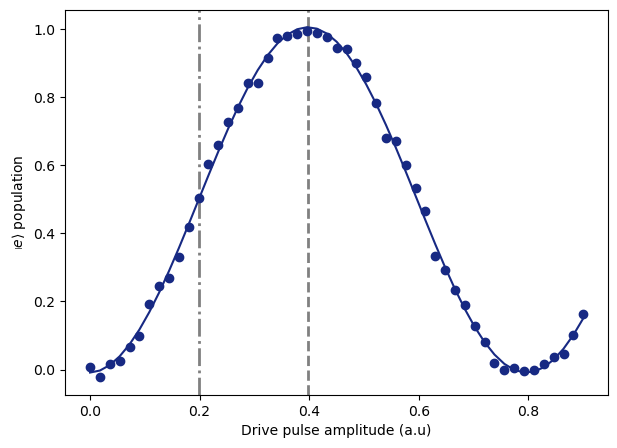

In [188]:
handles = list(rabi_res.acquired_results.keys())
res1 = np.asarray(rabi_res.get_data(handles[0]))
res_cal_trace= np.asarray(rabi_res.get_data(handles[1]))
axis1 = rabi_res.get_axis(handles[0])[0]
delta_x = axis1[-1]-axis1[-2]
axis2 = np.linspace(axis1[-1]+delta_x,axis1[-1] + 2*delta_x,2)

delta_vec = res_cal_trace[1] -res_cal_trace[0]
angle = np.angle(delta_vec)
rd = []
for r in [res1,res_cal_trace]:
    r = r - res_cal_trace[0]
    r = r * np.exp(-1j*angle)
    r = r/ np.abs(delta_vec)
    rd.append(r)
    
offset_guess = np.mean(np.real(rd[0]))
phase_shift_guess = np.pi / 2
amplitude_guess = (max(np.real(rd[0])) - min(np.real(rd[0]))) / 2
period_guess = abs(axis1[np.argmax(np.real(rd[0]))] - axis1[np.argmin(np.real(rd[0]))])
p0 = [offset_guess, phase_shift_guess, amplitude_guess, period_guess]
popt = scipy.optimize.curve_fit(rabi_curve, axis1, np.real(rd[0]), p0=p0)[0]

pi_amp = scipy.optimize.fmin(
    lambda x: -rabi_curve(x, *popt), axis1[np.argmax(np.real(rd[0]))], disp=False
)[0]
pi2_amp = scipy.optimize.fmin(
    lambda x: abs(rabi_curve(x, *popt) - popt[0]), pi_amp / 2, disp=False
)[0]

plt.figure(figsize=(7, 5))
plt.xlabel('Drive pulse amplitude (a.u)')
plt.ylabel(r"$\left| e\right\rangle$ population")
plt.plot(axis1,np.real(rd[0]),'o', color = dark_blue_color_zi)
plt.plot(axis1, rabi_curve(axis1, *popt), color = dark_blue_color_zi)
plt.axvline(x=pi_amp, color='gray', linestyle='--', linewidth=2, zorder = -1)
plt.axvline(x=pi2_amp, color='gray', linestyle='-.', linewidth=2, zorder = -1)


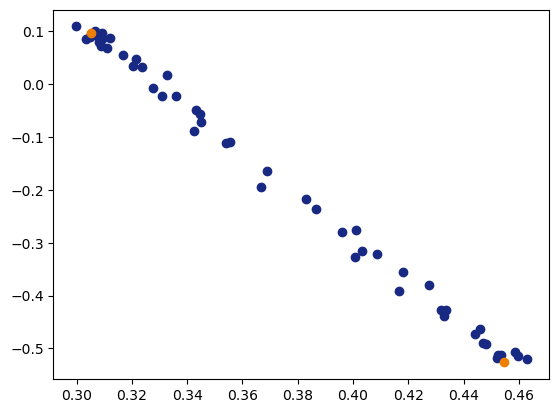

In [189]:
plt.plot(np.real(res1), np.imag(res1), "o", color = dark_blue_color_zi)
plt.plot(np.real(res_cal_trace[0]), np.imag(res_cal_trace[0]), "o", color = orange_color_zi)
plt.plot(np.real(res_cal_trace[1]), np.imag(res_cal_trace[1]), "o", color = orange_color_zi)

In [190]:
qubit_parameters["qubits"]["q0"]["amplitude_pi"][
    "value"
] = float(pi_amp)
qubit_parameters["qubits"]["q0"]["amplitude_pi2"][
    "value"
] = float(pi2_amp)


transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

## T1 measurement

In [29]:
delay_sweep=LinearSweepParameter(uid="delay_sweep", start=1e-10, stop=100e-6, count=51)

t1_meas = t1_parallel(
    qubits=[transmon_list[0]],
    drive_pulse=qubit_drive_pulse,
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    delay_sweep=delay_sweep,
    num_averages=2**10,
)

compiled_t1 = session.compile(t1_meas)
session.connect(do_emulation=emulate, reset_devices=True)
t1_res = session.run(compiled_t1)

2023.09.29 16:25:51.766 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.29 16:25:51.786 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.29 16:25:51.821 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 312
2023.09.29 16:25:51.822 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 3616
2023.09.29 16:25:51.822 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.
2023.09.29 16:25:51.823 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.29 16:25:51.823 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.29 16:25:51.829 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.29 16:25:53.278 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.29 16:25:53.425 laboneq.controller.devices.device

T1 found to be 21.285 us.


2.1285450411156225e-05

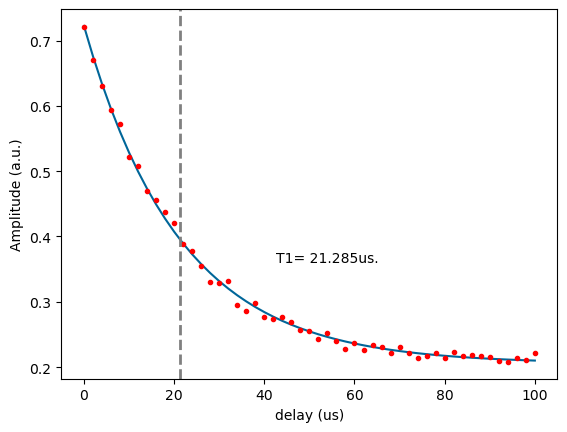

In [30]:
evaluate_T1(t1_res, "q0_t1")

## Ramsey

In [294]:
def ramsey_parallel(
    qubits,
    drive_pulse: callable,
    pi_drive_pulse: callable,
    integration_kernel: callable,
    readout_pulse: callable,
    delay_sweep,
    num_averages=2**10,
    detuning = 0,
    cal_trace=False,
):
    exp_ramsey = Experiment(
        uid="Ramsey Exp",
        signals=flatten(
            [
                [
                    ExperimentSignal(
                        f"drive_{qubit.uid}", map_to=qubit.signals["drive"]
                    ),
                    ExperimentSignal(
                        f"measure_{qubit.uid}", map_to=qubit.signals["measure"]
                    ),
                    ExperimentSignal(
                        f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]
                    ),
                ]
                for qubit in qubits
            ]
        ),
    )


    

 #   readout_weight = readout_pulse
    freq = qubits[0].parameters.resonance_frequency_ge + detuning - qubits[0].parameters.drive_lo_frequency
  #  else:
   #     freq = detuning
         
    
    calibration = Calibration()   
    calibration["drive_q0"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq,
            modulation_type=ModulationType.HARDWARE
        )
    )

    exp_ramsey.set_calibration(calibration)

    ## define Ramsey experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_ramsey.acquire_loop_rt(
        uid="ramsey_shots",
        count=num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
        for qubit in qubits:
            # inner loop - real time sweep of Ramsey time delays
            with exp_ramsey.sweep(
                uid="ramsey_sweep", parameter=delay_sweep, alignment=SectionAlignment.RIGHT
            ):
                # play qubit excitation pulse - pulse amplitude is swept
                ramsey_pulse = drive_pulse(qubit)
                with exp_ramsey.section(
                    uid=f"{qubit.uid}_excitation", alignment=SectionAlignment.RIGHT
                ):
                    exp_ramsey.play(signal=f"drive_{qubit.uid}", pulse=ramsey_pulse)
                    exp_ramsey.delay(signal=f"drive_{qubit.uid}", time=delay_sweep)
                    exp_ramsey.play(signal=f"drive_{qubit.uid}", pulse=ramsey_pulse)
                # readout pulse and data acquisition
                # measurement
                with exp_ramsey.section(
                    uid=f"readout_{qubit.uid}", play_after=f"{qubit.uid}_excitation"
                ):
                    exp_ramsey.measure(
                        measure_signal=f"measure_{qubit.uid}",
                        measure_pulse=readout_pulse(qubit),
                        handle=f"{qubit.uid}_ramsey",
                        acquire_signal=f"acquire_{qubit.uid}",
                        integration_kernel=integration_kernel(qubit),
                        reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                    )
                    
                
            if cal_trace:
                with exp_ramsey.section(uid="cal_trace_gnd"):
                    exp_ramsey.measure(
                        measure_signal=f"measure_{qubit.uid}",
                        measure_pulse=readout_pulse(qubit),
                        handle=f"{qubit.uid}_ramsey_cal_trace",
                        acquire_signal=f"acquire_{qubit.uid}",
                        integration_kernel=integration_kernel(qubit),
                        reset_delay=1e-6 # qubit.parameters.user_defined["reset_delay_length"],
                    )
                cal_e_pulse = pi_drive_pulse(qubit)#, amplitude = 1)
                with exp_ramsey.section(uid="cal_trace_exc", play_after="cal_trace_gnd"):
                    # exp_ramsey.play(
                    #     signal=f"drive_{qubit.uid}",
                    #     pulse=cal_e_pulse,
                    #   #  amplitude = transmon_list[0].parameters.user_defined["amplitude_pi"],
                    # )
                    exp_ramsey.play(signal=f"drive_{qubit.uid}", pulse=ramsey_pulse)
                    exp_ramsey.play(signal=f"drive_{qubit.uid}", pulse=ramsey_pulse)
                    
                with exp_ramsey.section(uid="cal_trace_exc_meas", play_after="cal_trace_exc"):
                    exp_ramsey.measure(
                        measure_signal=f"measure_{qubit.uid}",
                        measure_pulse=readout_pulse(qubit),
                        handle=f"{qubit.uid}_ramsey_cal_trace",
                        acquire_signal=f"acquire_{qubit.uid}",
                        integration_kernel=integration_kernel(qubit),
                        reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                    )

    return exp_ramsey

In [295]:
qubit_parameters["qubits"]["q0"]["reset_delay_length"]["value"] = 100e-6
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [296]:
def qubit_gaussian_pulse(qubit):
    return pulse_library.gaussian(
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude = qubit.parameters.user_defined["amplitude_pi"],
    )

def qubit_gaussian_halfpi_pulse(qubit):
    return pulse_library.gaussian(
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude = qubit.parameters.user_defined["amplitude_pi2"],
    )

### Set detuning freq

In [297]:
detuning_freq = .05e6

In [298]:
delay_sweep = LinearSweepParameter(uid="delay_sweep", start=0, stop=40e-6, count=151)
ramsey_exp = ramsey_parallel(transmon_list, qubit_gaussian_halfpi_pulse, qubit_gaussian_pulse, integration_kernel, readout_pulse, delay_sweep, num_averages=2**10, detuning=detuning_freq, cal_trace=True)
session.connect(reset_devices=True)
compiled_exp = session.compile(ramsey_exp)
res_ramsey=session.run(compiled_exp)
#show_pulse_sheet(ramsey_exp.uid,compiled_exp)

2023.10.03 11:38:11.089 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.10.03 11:38:11.090 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.10.03 11:38:11.096 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.10.03 11:38:12.485 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.10.03 11:38:12.681 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.10.03 11:38:12.875 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.10.03 11:38:12.895 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.10.03 11:38:12.988 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 1391
2023.10.03 11:38:12.988 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 5696
2023.10.03 11:38:12.989 laboneq.compiler.workfl

In [299]:
def ramsey_curve(x, offset, phase_shift, amplitude, period, t2):
        return (
            amplitude * np.exp(-x / t2) * np.sin(2 * np.pi * x / period + phase_shift)
            + offset
        )

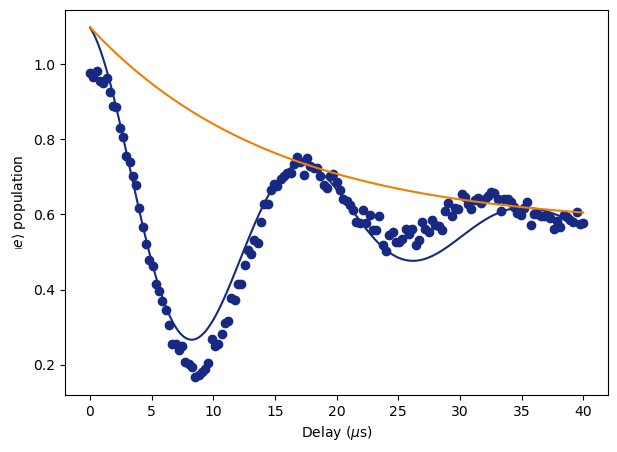

In [300]:
handles = list(res_ramsey.acquired_results.keys())
res1 = np.asarray(res_ramsey.get_data(handles[0]))
res_cal_trace= np.asarray(res_ramsey.get_data(handles[1]))
axis1 = res_ramsey.get_axis(handles[0])[0]

delta_vec = res_cal_trace[1] - res_cal_trace[0]
angle = np.angle(delta_vec)
rd = []
for r in [res1,res_cal_trace]:
    r = r - res_cal_trace[0]
    r = r * np.exp(-1j*angle)
    r = r/ np.abs(delta_vec)
    rd.append(r)

offset_guess = np.mean(np.real(rd[0]))
phase_shift_guess = np.pi / 2 if np.real(rd[0])[0] > np.real(rd[0])[-1] else -np.pi / 2
amplitude_guess = (max(np.real(rd[0])) - min(np.real(rd[0]))) / 2
period_guess = 2 * abs(axis1[np.argmax(np.real(rd[0]))] - axis1[np.argmin(np.real(rd[0]))])
t2_guess = 10e-6
# TODO: Refine t2 guess algorithm, potentially by finding peaks and fitting only them

p0 = [offset_guess, phase_shift_guess, amplitude_guess, period_guess, t2_guess]
popt = scipy.optimize.curve_fit(ramsey_curve, axis1, np.real(rd[0]), p0=p0)[0]

t2 = popt[4]
detuning_freq_measured = 1 / popt[3]

envelope_param = np.copy(popt)
envelope_param[3] = 1e9
envelope_param[1] = np.pi / 2

x_fit = np.linspace(axis1[0], axis1[-1], 1000)

plt.figure(figsize=(7, 5))
plt.xlabel(r'Delay ($\mu$s)')
plt.ylabel(r"$\left| e\right\rangle$ population")
plt.plot(axis1*1e6,np.real(rd[0]),'o', color = dark_blue_color_zi)
plt.plot(x_fit*1e6, ramsey_curve(x_fit, *popt), color = dark_blue_color_zi)
plt.plot(axis1*1e6, ramsey_curve(axis1, *envelope_param), color = orange_color_zi)


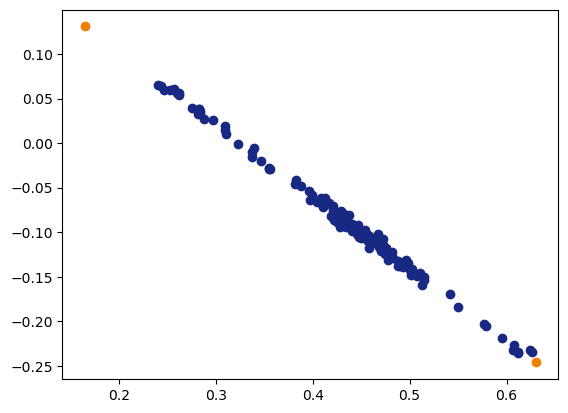

In [301]:
plt.plot(np.real(res1), np.imag(res1), "o", color = dark_blue_color_zi)
plt.plot(np.real(res_cal_trace[0]), np.imag(res_cal_trace[0]), "o", color = orange_color_zi)
plt.plot(np.real(res_cal_trace[1]), np.imag(res_cal_trace[1]), "o", color = orange_color_zi)

In [302]:
print('T2 = {:.3f} us'.format(1e6*t2))

T2 = 15.034 us


In [303]:
detuning_freq_measured

55723.33689970683

### Update qubit resonance frequency

In [250]:
qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"][
    "value"
] = float(qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"][
    "value"
] - detuning_freq_measured + detuning_freq)
print(qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"]["value"])
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

5748946375.423385


# Active reset

## Optimize resonance freq

In [251]:
# resonator_spectroscopy gnd
gnd_cw = resonator_spectroscopy_g_vs_e(
    transmon_list[0],
    drive_pulse = None,
    readout_pulse=readout_gauss_square_pulse,
    integration_kernel=integration_kernel,
    frequency_sweep = create_freq_sweep(f"{transmon_list[0].uid}_sweep_g", 210e6, 290e6, 201),
    measure_range=-25,
    acquire_range=-5,
    num_averages=2**12,
)
session.connect(do_emulation=emulate, reset_devices=True)
compiled_gnd_cw = session.compile(gnd_cw)
show_pulse_sheet("gnd_cw", compiled_gnd_cw)
gnd_cw_results = session.run(compiled_gnd_cw)

2023.09.29 17:18:42.566 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.29 17:18:42.566 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.29 17:18:42.572 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.29 17:18:44.045 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.29 17:18:44.191 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.29 17:18:44.411 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.29 17:18:44.441 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.29 17:18:44.521 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 24
2023.09.29 17:18:44.523 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 3200
2023.09.29 17:18:44.524 laboneq.compiler.workflow

In [252]:
# resonator_spectroscopy_pi
excitation_cw = resonator_spectroscopy_g_vs_e(
    transmon_list[0],
    drive_pulse = qubit_drive_pulse,
    readout_pulse=readout_gauss_square_pulse,
    integration_kernel=integration_kernel,
    frequency_sweep = create_freq_sweep(f"{transmon_list[0].uid}_sweep_e", 210e6, 290e6, 201),
    measure_range=-25,
    acquire_range=-5,
    num_averages=2**12,
)
session.connect(do_emulation=emulate, reset_devices=True)
compiled_excitation_cw = session.compile(excitation_cw)
show_pulse_sheet("exc_cw", compiled_excitation_cw)
excitation_cw_results = session.run(compiled_excitation_cw)

2023.09.29 17:18:48.623 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.29 17:18:48.624 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.29 17:18:48.628 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.29 17:18:50.026 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.29 17:18:50.170 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.29 17:18:50.357 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.29 17:18:50.388 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.29 17:18:50.524 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 37
2023.09.29 17:18:50.524 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 3616
2023.09.29 17:18:50.525 laboneq.compiler.workflow

### Optimize readout freq based on IQ distance

In [253]:
lo_frequency = gnd_cw_results.experiment.signals["measure_q0"].calibration.local_oscillator.frequency

gnd_signal = gnd_cw_results.get_data("resonator_spectroscopy_q0")
exc_signal = excitation_cw_results.get_data("resonator_spectroscopy_q0")
full_sweep = gnd_cw_results.get_axis("resonator_spectroscopy_q0")[0] + lo_frequency

In [254]:
diff_res_signal = abs(exc_signal - gnd_signal)
max_res_signal = np.max(diff_res_signal)
max_res_signal_idx = np.argmax(diff_res_signal)
opt_res_freq = full_sweep[np.argmax(diff_res_signal)]
print(f"Optimized res freq {opt_res_freq/1e9} GHz gives max signal {max_res_signal}")

Optimized res freq 7.26 GHz gives max signal 0.00011752133677167115


In [255]:
qubit_parameters["qubits"]["q0"]["readout_resonator_frequency"][
    "value"
] = float(opt_res_freq)

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

### Nice plot for optimized resonator readout frequency

Text(0, 0.5, 'Q (norm.)')

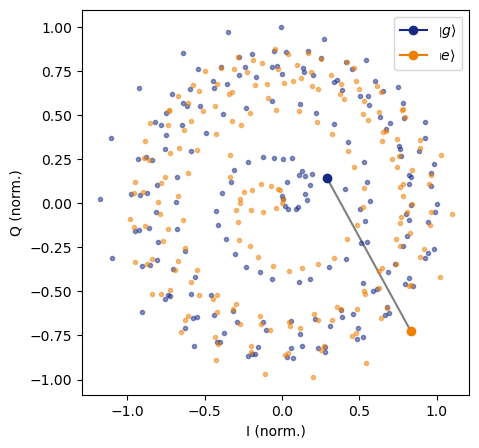

In [256]:
fig = plt.figure(figsize=(5, 5))

plt.plot(np.real(gnd_signal)/np.max(np.real(gnd_signal)), np.imag(gnd_signal)/np.max(np.imag(gnd_signal)), '.', color=dark_blue_color_zi, alpha = 0.5)
plt.plot(np.real(exc_signal)/np.max(np.real(gnd_signal)), np.imag(exc_signal)/np.max(np.imag(gnd_signal)), '.', color=orange_color_zi, alpha = 0.5)

opt_real = [np.real(gnd_signal[max_res_signal_idx])/np.max(np.real(gnd_signal)), np.real(exc_signal[max_res_signal_idx])/np.max(np.real(gnd_signal))]
opt_imag = [np.imag(gnd_signal[max_res_signal_idx])/np.max(np.imag(gnd_signal)), np.imag(exc_signal[max_res_signal_idx])/np.max(np.imag(gnd_signal))]

plt.plot(opt_real[0], opt_imag[0], color = dark_blue_color_zi, marker = 'o', label=r"$\left| g\right\rangle$")
plt.plot(opt_real[1], opt_imag[1], color = orange_color_zi, marker = 'o', label=r"$\left| e\right\rangle$")
plt.plot(opt_real, opt_imag, color = 'grey', zorder = -1)

plt.legend()
plt.xlabel("I (norm.)")
plt.ylabel("Q (norm.)")

### Nice plot for resonator spectroscopy in g and e

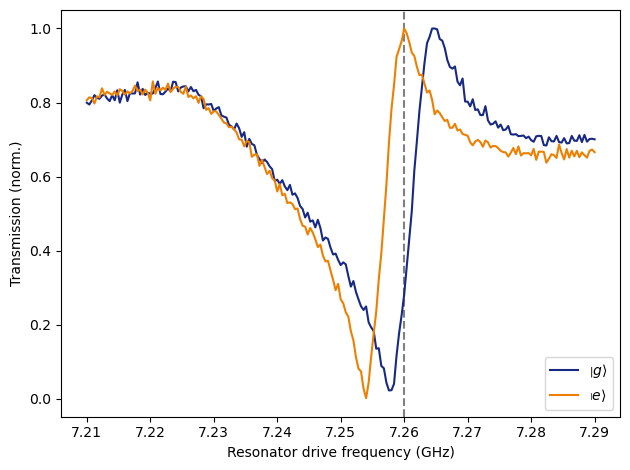

In [257]:
lo_frequency = gnd_cw_results.experiment.signals["measure_q0"].calibration.local_oscillator.frequency

gnd_signal = abs(gnd_cw_results.get_data("resonator_spectroscopy_q0"))

gnd_signal = gnd_signal/max(gnd_signal)

exc_signal = abs(excitation_cw_results.get_data("resonator_spectroscopy_q0"))
full_sweep2 = excitation_cw_results.get_axis("resonator_spectroscopy_q0")[0] + lo_frequency
exc_signal = exc_signal/max(exc_signal)

plt.plot(full_sweep/1e9, gnd_signal, label=r"$\left| g\right\rangle$", color=dark_blue_color_zi)
plt.plot(full_sweep2/1e9, exc_signal, label=r"$\left| e\right\rangle$", color=orange_color_zi)
plt.axvline(x=opt_res_freq/1e9, linestyle='--', color = 'grey', zorder=-1)
plt.xlabel("Resonator drive frequency (GHz)")
plt.ylabel("Transmission (norm.)")
plt.legend(loc = "lower right")
plt.tight_layout()

## Optimize kernels

In [258]:
def gen_exp_ref_trace(
    qubit,
    drive_pulse,
    readout_pulse,
    num_averages=2**8,
    excited=True,
):
    measure_pulse = readout_pulse(qubit)
    integration_length = measure_pulse.length + 300e-9
    print(f"integration length {integration_length}")
    exp_uid = "Exp_ref_trace_exc"
    
    exp_ref_trace = Experiment(
        uid=exp_uid,
        signals=[
            ExperimentSignal(f"measure_{qubit.uid}", map_to=qubit.signals["measure"]),
            ExperimentSignal(f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]),
            ExperimentSignal(f"drive_{qubit.uid}", map_to=qubit.signals["drive"]),
        ],
    )
    
    ## define experimental sequence
    with exp_ref_trace.acquire_loop_rt(
        uid="shots",
        count=num_averages,
        acquisition_type=AcquisitionType.RAW,
        #acquisition_type=AcquisitionType.INTEGRATION,
    ):
        if excited:
            with exp_ref_trace.section(uid="excitation"):
                exp_ref_trace.play(signal=f"drive_{qubit.uid}", pulse=drive_pulse(qubit))
        else:
            with exp_ref_trace.section(uid="excitation"):
                exp_ref_trace.play(signal=f"drive_{qubit.uid}", pulse=drive_pulse(qubit), amplitude=0)

        with exp_ref_trace.section(uid=f"raw_{qubit.uid}_g",play_after="excitation"):
            exp_ref_trace.play(signal=f"measure_{qubit.uid}", pulse=measure_pulse)
            exp_ref_trace.acquire(signal=f"acquire_{qubit.uid}", handle=f"raw_{qubit.uid}", length=integration_length)
            exp_ref_trace.delay(signal=f"measure_{qubit.uid}", time=qubit.parameters.user_defined["reset_delay_length"])
            exp_ref_trace.delay(signal=f"acquire_{qubit.uid}", time=qubit.parameters.user_defined["reset_delay_length"])

    cal = Calibration()
    cal[f"acquire_{qubit.uid}"] = SignalCalibration(
        oscillator=None,
        port_delay=240e-9,
    )
    exp_ref_trace.set_calibration(cal)

    return exp_ref_trace

In [259]:
soft_avg = 5

gnd_ref = gen_exp_ref_trace(
    transmon_list[0],
    drive_pulse = qubit_drive_pulse,
    readout_pulse=readout_pulse,
    num_averages=2**15,
    excited=False
)
session.connect(do_emulation=False, reset_devices=True)
results_e = []
for avg in range(soft_avg):
    gnd_ref_results = session.run(gnd_ref)
    results_e.append(gnd_ref_results.get_data("raw_q0"))
show_pulse_sheet("exc_ref", gnd_ref_results.compiled_experiment)

results_g = results_e


exc_ref = gen_exp_ref_trace(
    transmon_list[0],
    drive_pulse = qubit_drive_pulse,
    readout_pulse=readout_pulse,
    num_averages=2**15,
    excited=True
)
session.connect(do_emulation=False, reset_devices=True)
results_e = []
for avg in range(soft_avg):
    exc_ref_results = session.run(exc_ref)
    results_e.append(exc_ref_results.get_data("raw_q0"))
show_pulse_sheet("exc_ref", exc_ref_results.compiled_experiment)

integration length 1.1e-06
2023.09.29 17:20:16.981 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.29 17:20:16.981 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.29 17:20:16.986 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.29 17:20:18.362 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.29 17:20:18.512 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.29 17:20:18.760 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.29 17:20:18.765 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.29 17:20:18.777 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 20
2023.09.29 17:20:18.777 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 2016
2023.09.29 17:20:18.77

c:\Users\ZI_at_PSI\code\Tune_up_scripts\exc_ref_2023-09-29-17-21-06.html

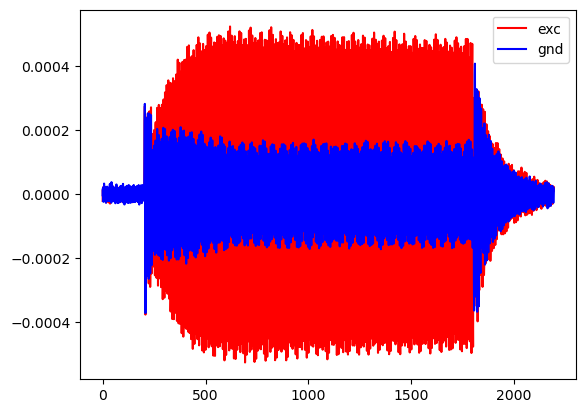

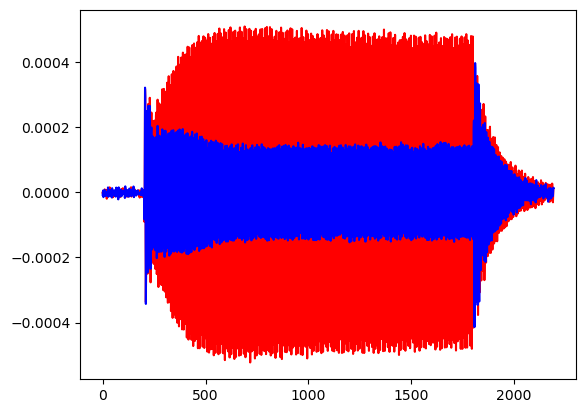

In [260]:
g_raw = np.mean(results_g, axis = 0)
e_raw = np.mean(results_e, axis = 0)

plt.plot(np.real(e_raw),c='red', label='exc')
plt.plot(np.real(g_raw),c='blue', label='gnd')
plt.legend()
plt.figure()

plt.plot(np.imag(e_raw),'r')
plt.plot(np.imag(g_raw),'b')

In [261]:
e_raw = e_raw[:-(len(e_raw)%16)]    
g_raw = g_raw[:-(len(g_raw)%16)]


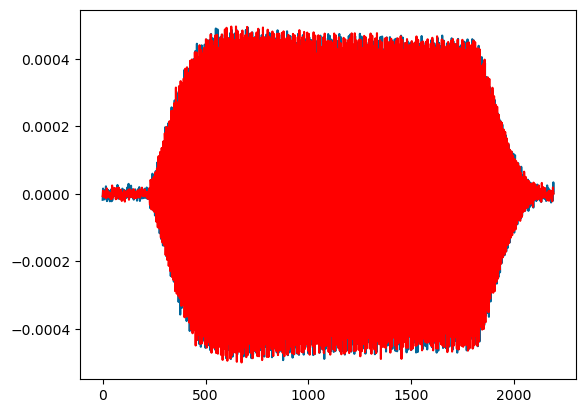

In [262]:

samples_kernel = np.conj(e_raw - g_raw)
plt.figure()
plt.plot(samples_kernel.real)
plt.plot(samples_kernel.imag)

In [304]:
def exp_int(
    qubit,
    drive_pulse,
    readout_pulse,
    integration_kernel,
    num_averages=2**8,
    use_modulated_kernel=False,
    acquisition_type=AcquisitionType.INTEGRATION,
    threshold=0.0,
):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_int = Experiment(
        uid="Exp_integration",
        signals=[
            ExperimentSignal(f"measure_{qubit.uid}", map_to=qubit.signals["measure"]),
            ExperimentSignal(f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]),
            ExperimentSignal(f"drive_{qubit.uid}", map_to=qubit.signals["drive"]),
        ],
    )
    measure_pulse = readout_pulse(qubit)
    print(f"measure pulse length {measure_pulse.length}")
    try:
        integration_kernel= integration_kernel(qubit)
    except Exception as e:
        print(e)
        integration_kernel = integration_kernel
    with exp_int.acquire_loop_rt(
        uid="shots",
        count=num_averages,
        averaging_mode=AveragingMode.SINGLE_SHOT,
        #acquisition_type=AcquisitionType.RAW,
        acquisition_type=acquisition_type,
    ):
        with exp_int.section(uid="gnd_measure"):
            exp_int.measure(
                measure_signal=f"measure_{qubit.uid}",
                measure_pulse=measure_pulse,
                handle=f"{qubit.uid}_int_g",
                acquire_signal=f"acquire_{qubit.uid}",
                integration_kernel=integration_kernel,
                reset_delay=qubit.parameters.user_defined["reset_delay_length"],
            )
        with exp_int.section(uid="excitation",play_after="gnd_measure"):
            exp_int.play(signal=f"drive_{qubit.uid}", pulse = drive_pulse(qubit))
        with exp_int.section(uid="exc_measure",play_after="excitation"):
            exp_int.measure(
                measure_signal=f"measure_{qubit.uid}",
                measure_pulse=measure_pulse,
                handle=f"{qubit.uid}_int_e",
                acquire_signal=f"acquire_{qubit.uid}",
                integration_kernel=integration_kernel,
                reset_delay=qubit.parameters.user_defined["reset_delay_length"],
            )
    if not use_modulated_kernel:
        cal = Calibration()

        cal[f"acquire_{qubit.uid}"] = SignalCalibration(
            oscillator=Oscillator(frequency=0),
            threshold=threshold
        )
        exp_int.set_calibration(cal)
    return exp_int


In [305]:
normalized_samples_kernel=samples_kernel/np.max(np.abs(samples_kernel))

In [306]:
np.abs(samples_kernel)

array([1.87226210e-05, 6.15173149e-06, 1.85584456e-05, ...,
       1.10870295e-05, 3.45291413e-05, 2.08014500e-06])

In [307]:
do_rotation = True
modulate_kernel = False
#modulate_kernel = True
rotation_angle=-2.16
int_kernel = pulse_library.sampled_pulse_complex(
        normalized_samples_kernel * np.exp(1j * rotation_angle)
    )
#int_kernel = integration_kernel
my_exp = exp_int(
    transmon_list[0],
    qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    num_averages=2**10,
    use_modulated_kernel=modulate_kernel,
)
    
session.connect(do_emulation=False, reset_devices=True)
res_int = session.run(my_exp)


measure pulse length 8e-07
'PulseSampledComplex' object is not callable
2023.10.03 11:38:49.938 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.10.03 11:38:49.939 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.10.03 11:38:49.947 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.10.03 11:38:51.361 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.10.03 11:38:51.500 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.10.03 11:38:51.715 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.10.03 11:38:51.720 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.10.03 11:38:51.745 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 24
2023.10.03 11:38:51.746 laboneq.compiler.workflow.compiler INFO   Total sample 

Using threshold = 3.717021e-01 and rotation angle: -5.947374e-01


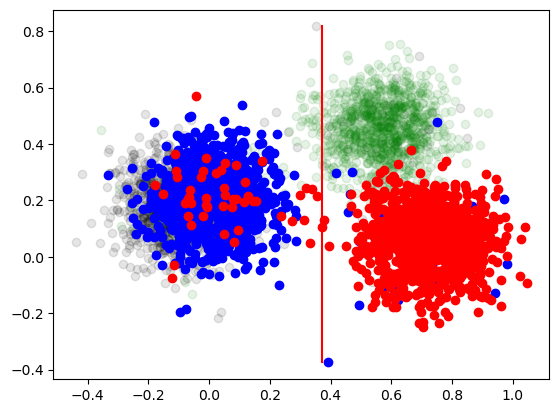

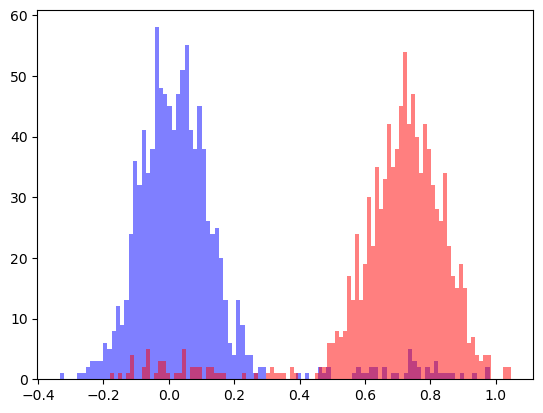

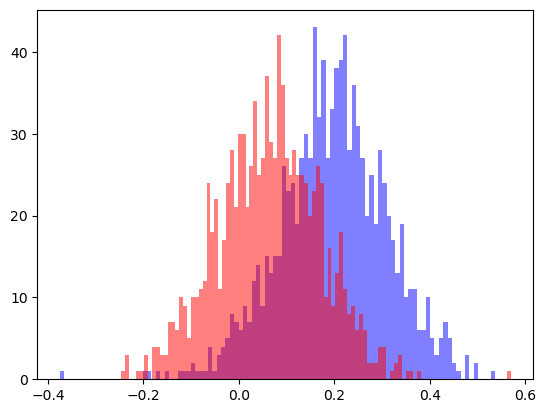

In [308]:
res0 = res_int.get_data("q0_int_g")
res1 = res_int.get_data("q0_int_e")

connect_vector = np.median(res1) - np.median(res0)
if do_rotation:
    rotation_angle = -np.angle(connect_vector)
else:
    rotation_angle = 0

res0_rot = res0 * np.exp(1j * rotation_angle)
res1_rot = res1 * np.exp(1j * rotation_angle)

my_threshold = (np.median(res0_rot.real) + np.median(res1_rot.real)) / 2

if do_rotation:
    plt.scatter(res0.real, res0.imag, c="k", alpha=0.1)
    plt.scatter(res1.real, res1.imag, c="g", alpha=0.1)

plt.scatter(res0_rot.real, res0_rot.imag, c="b")
plt.scatter(res1_rot.real, res1_rot.imag, c="r")
plt.plot(
    [my_threshold, my_threshold],
    [
        min([*res0_rot.imag, *res1_rot.imag, *res0.imag, *res1.imag]),
        max([*res0_rot.imag, *res1_rot.imag, *res0.imag, *res1.imag]),
    ],
    "r",
)
if do_rotation:
    print(f"Using threshold = {my_threshold:e} and rotation angle: {rotation_angle:e}")
else:
    print(f"Using threshold={my_threshold:e}")

plt.figure()
plt.hist(res0_rot.real, bins=100, alpha=0.5,color="blue");
plt.hist(res1_rot.real, bins=100, alpha=0.5,color="red");

plt.figure()
plt.hist(res0_rot.imag, bins=100, alpha=0.5,color="blue");
plt.hist(res1_rot.imag, bins=100, alpha=0.5,color="red");

# Calculate Fidelity

In [309]:
def calculate_fidelity(res0_rot,res1_rot,threshold):
    prepared_g_measured_g = np.count_nonzero(res0_rot.real < threshold)/len(res0_rot.real)
    prepared_g_measured_e = np.count_nonzero(res0_rot.real > threshold)/len(res0_rot.real)
    prepared_e_measured_g = np.count_nonzero(res1_rot.real < threshold)/len(res1_rot.real)
    prepared_e_measured_e = np.count_nonzero(res1_rot.real > threshold)/len(res1_rot.real)

    # plot heatmap with 4 squares
    assignment_matrix =[ [prepared_g_measured_g,prepared_g_measured_e],[prepared_e_measured_g,prepared_e_measured_e]]

    fig, ax = plt.subplots()
    im = ax.imshow(assignment_matrix, cmap='Reds', vmin=0, vmax=1)
    for i in range(2):
        for j in range(2):
            # add text annotations format with 2 decimals float
            text = ax.text(j, i, f"{assignment_matrix[i][j]:.2f}",
                        ha="center", va="center", color="black", fontsize=16)
    # plot colorbar to the right, label it with label with font size
    cbar = ax.figure.colorbar(im, ax=ax,)
    cbar.set_label( label="Assignment Probability",size=16)

    # set axis labels
    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))

    ax.set_xticklabels(["g", "e"], fontsize=16)
    ax.set_yticklabels(["g", "e"], fontsize=16)
    ax.set_xlabel("Prepared State",fontsize=16)

    fidelity = (  1- prepared_g_measured_e - prepared_e_measured_g )
    print(f"ee:{prepared_e_measured_e}")
    print(f"gg:{prepared_g_measured_g}")
    print(f"eg:{prepared_e_measured_g}")
    print(f"ge:{prepared_g_measured_e}")
    print(f"Fidelity {fidelity}")

    ax.text(0.5, 2.0, f"Average Fidelity {fidelity:.2f}", size=16, ha="center")
    plt.tight_layout()

    return fidelity

ee:0.951171875
gg:0.9560546875
eg:0.048828125
ge:0.0439453125
Fidelity 0.9072265625


0.9072265625

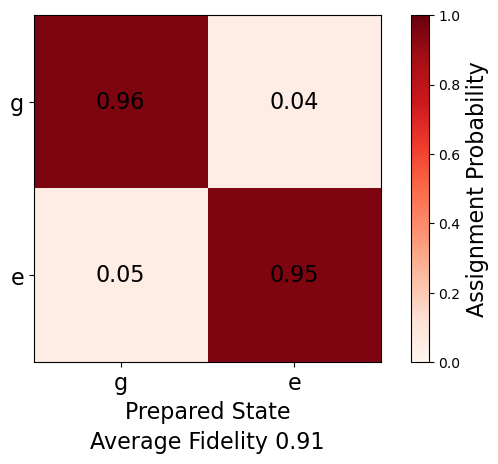

In [310]:
calculate_fidelity(res0_rot,res1_rot,my_threshold)

# Discrimination exp

In [311]:
disc_exp = exp_int(
    transmon_list[0],
    qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    num_averages=2**10,
    use_modulated_kernel=False,
    acquisition_type=AcquisitionType.DISCRIMINATION,
    threshold=my_threshold,
)
    
session.connect(do_emulation=False, reset_devices=True)
res_disc = session.run(disc_exp)

measure pulse length 8e-07
'PulseSampledComplex' object is not callable
2023.10.03 11:39:01.216 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.10.03 11:39:01.217 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.10.03 11:39:01.224 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.10.03 11:39:02.609 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.10.03 11:39:02.750 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.10.03 11:39:02.941 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.10.03 11:39:02.946 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.10.03 11:39:02.953 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 24
2023.10.03 11:39:02.954 laboneq.compiler.workflow.compiler INFO   Total sample 

In [312]:
print(res_disc.acquired_results)
res_dis_q0_g=res_disc.get_data("q0_int_g")
res_dis_q0_e=res_disc.get_data("q0_int_e")
print(np.mean(res_dis_q0_g))
print(np.mean(res_dis_q0_e))

{'q0_int_g': AcquiredResult(data=array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]), axis_name=['shots'], axis=[array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.021e+03, 1.022e+03,
       1.023e+03])], last_nt_step=[]), 'q0_int_e': AcquiredResult(data=array([1.+0.j, 0.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j]), axis_name=['shots'], axis=[array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.021e+03, 1.022e+03,
       1.023e+03])], last_nt_step=[])}
(0.0380859375+0j)
(0.931640625+0j)


# Active reset

In [313]:
def gen_active_reset_exp(
    qubit,
    integration_kernel,
    prepare_pulse:callable,
    pi_pulse: callable,
    readout_pulse,
    prepare_pulse_phase =0,
    num_average=1024,
    threshold=0,
    num_rst=10,
):
    exp = Experiment(
        signals=[
            ExperimentSignal(f"measure_{qubit.uid}", map_to=qubit.signals["measure"]),
            ExperimentSignal(f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]),
            ExperimentSignal(f"drive_{qubit.uid}", map_to=qubit.signals["drive"]),
        ],
    )

    with exp.acquire_loop_rt(
        count=num_average,
        averaging_mode=AveragingMode.SINGLE_SHOT,
        acquisition_type=AcquisitionType.DISCRIMINATION,
    ):

        # qubit state readout
        with exp.section(uid="prepare"):
            exp.play(signal=f"drive_{qubit.uid}", pulse=prepare_pulse(qubit),amplitude=1, phase = prepare_pulse_phase)

        for i in range(num_rst):
            if i==0:
                measure_playafter="prepare"
            else:
                measure_playafter=f"feedback_{i-1}"
            with exp.section(uid=f"measure_{i}",play_after=measure_playafter):
                exp.measure(
                    measure_signal=f"measure_{qubit.uid}",
                    measure_pulse=readout_pulse(qubit),
                    handle=f"{qubit.uid}_bf_rst_{i}",
                    #handle="fb_measure",
                    acquire_signal=f"acquire_{qubit.uid}",
                    integration_kernel=integration_kernel,
                    reset_delay=500e-9,
                )

            with exp.match(
                uid=f"feedback_{i}",
                handle=f"{qubit.uid}_bf_rst_{i}",
                #andle="fb_measure",
                play_after=f"measure_{i}",
            ):
                with exp.case(state=0):
                    exp.play(signal=f"drive_{qubit.uid}", pulse=pi_pulse(qubit),amplitude=0)
                with exp.case(state=1):
                    # play x180 pulse
                    exp.play(signal=f"drive_{qubit.uid}", pulse=pi_pulse(qubit),amplitude=1)
        with exp.section(uid=f"posmeasure",play_after=f"feedback_{num_rst-1}"):
            exp.measure(
                measure_signal=f"measure_{qubit.uid}",
                measure_pulse=readout_pulse(qubit),
                handle=f"{qubit.uid}_rst",
                acquire_signal=f"acquire_{qubit.uid}",
                integration_kernel=integration_kernel,
                reset_delay=qubit.parameters.user_defined["reset_delay_length"],
            )
    cal= Calibration()
    cal[f"acquire_{qubit.uid}"] = SignalCalibration(
        oscillator=Oscillator(frequency=0),
        port_delay=240e-9,
        threshold=threshold,
    )

    exp.set_calibration(cal)

    return exp

In [314]:
reset_exp = gen_active_reset_exp(
    qubit=transmon_list[0],
    prepare_pulse = qubit_drive_pulse,
    pi_pulse=qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    threshold=my_threshold,
    num_rst=3,
)

session.connect(do_emulation=emulate, reset_devices=True)
res_reset = session.run(reset_exp)
show_pulse_sheet("reset", res_reset.compiled_experiment)
res_bf_rst = np.real(res_reset.get_data(f"q0_bf_rst_0"))
res_aft_rst = np.real(res_reset.get_data("q0_rst"))
print(np.count_nonzero(res_bf_rst)/len(res_bf_rst))
print(np.count_nonzero(res_aft_rst)/len(res_aft_rst))

2023.10.03 11:39:31.901 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.10.03 11:39:31.903 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.10.03 11:39:31.912 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.10.03 11:39:33.324 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.10.03 11:39:33.462 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.10.03 11:39:33.703 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.10.03 11:39:33.707 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.10.03 11:39:33.716 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 36
2023.10.03 11:39:33.716 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 4624
2023.10.03 11:39:33.717 laboneq.compiler.workflow

# Active reset fidelity as a function of number of reset cycles

In [315]:
def qubit_gaussian_halfpi_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pulse_drive_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude = qubit.parameters.user_defined["amplitude_pi2"],
    )

def empty_pulse(qubit):
    return pulse_library.gaussian(
        length = qubit.parameters.user_defined["pulse_length"],
        amplitude=0,
    )

In [401]:
num_avg_reset = 2**13

In [402]:
res_rst_e=[]
std_res_rst_e=[]
session.connect(do_emulation=emulate, reset_devices=True)
num_rst = 50
reset_exp_e = gen_active_reset_exp(
    qubit=transmon_list[0],
    prepare_pulse = qubit_drive_pulse,
    pi_pulse=qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    threshold=my_threshold,
    num_rst=num_rst,
    num_average=num_avg_reset,
)
    
res_reset_exp_e = session.run(reset_exp_e)
for i in range(num_rst):
    rst=np.real(res_reset_exp_e.get_data(f"q0_bf_rst_{i}"))
    #aft_rst=np.real(res_reset.get_data("q0_rst"))
    #res_rst_e.append(np.count_nonzero(rst)/len(rst))
    res_rst_e.append(np.mean(rst))
    std_res_rst_e.append(np.std(rst))

sem_res_rst_e = np.asarray(std_res_rst_e)/np.sqrt(num_avg_reset) 

2023.10.03 12:27:17.023 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.10.03 12:27:17.024 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.10.03 12:27:17.031 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.10.03 12:27:18.463 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.10.03 12:27:18.602 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.10.03 12:27:18.853 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.10.03 12:27:18.875 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.10.03 12:27:18.919 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 130
2023.10.03 12:27:18.920 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 4624
2023.10.03 12:27:18.920 laboneq.compiler.workflo

In [586]:
def repeat_exp(session, exp, n_experiments=2**7):
    session.connect(do_emulation=emulate, reset_devices=True)
    res = []
    for i in range(n_experiments):
        res.append(session.run(exp))
        if i % 10 == 0:
            print(f"Finished {i} experiments")
    # stitch results together
    # return combined results
    
    return res

def evaluate_active_reset_results(res):
    mean_res = []
    std_res = []
    for i in range(num_rst):
        rst = [res[j].get_data(f"q0_bf_rst_{i}") for j in range(len(res))]

        mean_res.append(np.mean(rst))
        std_res.append(np.std(rst))
    sem_res = np.asarray(std_res)/np.sqrt(num_avg_reset)

    return mean_res, std_res, sem_res


In [587]:
res_rst_g=[]
std_res_rst_g=[]
session.connect(do_emulation=emulate, reset_devices=True)
reset_exp_g = gen_active_reset_exp(
    qubit=transmon_list[0],
    prepare_pulse = empty_pulse,
    pi_pulse=qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    threshold=my_threshold,
    num_rst=num_rst,
    num_average=num_avg_reset,
)
    
# res_reset_exp_g = session.run(reset_exp_g)
# for i in range(num_rst):
#     rst=np.real(res_reset_exp_g.get_data(f"q0_bf_rst_{i}"))
#     #aft_rst=np.real(res_reset.get_data("q0_rst"))
#     #res_rst_g.append(np.count_nonzero(rst)/len(rst))
#     res_rst_g.append(np.mean(rst))
#     std_res_rst_g.append(np.std(rst))

# sem_res_rst_g = np.asarray(std_res_rst_g)/np.sqrt(num_avg_reset) 

res_rst_g, std_res_rst_g, sem_res_rst_g = evaluate_active_reset_results(repeat_exp(session, reset_exp_g, 2))


2023.10.04 10:52:21.186 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.10.04 10:52:21.188 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.10.04 10:52:21.198 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.10.04 10:52:22.630 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.10.04 10:52:22.782 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.10.04 10:52:23.072 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.10.04 10:52:23.072 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.10.04 10:52:23.078 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.10.04 10:52:24.434 laboneq.controller.devices.device_collection INFO   Config

In [404]:
res_rst_plus=[]
std_res_rst_plus=[]
session.connect(do_emulation=emulate, reset_devices=True)
reset_exp_plus = gen_active_reset_exp(
    qubit=transmon_list[0],
    prepare_pulse = qubit_gaussian_halfpi_pulse,
    pi_pulse=qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    threshold=my_threshold,
    num_rst=num_rst,
    num_average=num_avg_reset,
)
    
res_reset_exp_plus = session.run(reset_exp_plus)
for i in range(num_rst):
    rst=np.real(res_reset_exp_plus.get_data(f"q0_bf_rst_{i}"))
    res_rst_plus.append(np.mean(rst))
    std_res_rst_plus.append(np.std(rst))

sem_res_rst_plus = np.asarray(std_res_rst_plus)/np.sqrt(num_avg_reset)


2023.10.03 12:27:30.910 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.10.03 12:27:30.911 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.10.03 12:27:30.916 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.10.03 12:27:32.333 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.10.03 12:27:32.475 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.10.03 12:27:32.727 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.10.03 12:27:32.741 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.10.03 12:27:32.782 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 133
2023.10.03 12:27:32.783 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 5040
2023.10.03 12:27:32.783 laboneq.compiler.workflo

In [405]:
res_rst_minus=[]
std_res_rst_minus=[]
session.connect(do_emulation=emulate, reset_devices=True)
reset_exp_minus = gen_active_reset_exp(
    qubit=transmon_list[0],
    prepare_pulse = qubit_gaussian_halfpi_pulse,
    pi_pulse=qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    threshold=my_threshold,
    num_rst=num_rst,
    num_average=num_avg_reset,
    prepare_pulse_phase=np.pi,
)
    
res_reset_exp_minus = session.run(reset_exp_minus)
for i in range(num_rst):
    rst=np.real(res_reset_exp_minus.get_data(f"q0_bf_rst_{i}"))
    res_rst_minus.append(np.mean(rst))
    std_res_rst_minus.append(np.std(rst))

sem_res_rst_minus = np.asarray(std_res_rst_minus)/np.sqrt(num_avg_reset)

2023.10.03 12:27:37.823 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.10.03 12:27:37.824 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.10.03 12:27:37.829 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.10.03 12:27:39.228 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.10.03 12:27:39.372 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.10.03 12:27:39.608 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.10.03 12:27:39.632 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.10.03 12:27:39.664 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 133
2023.10.03 12:27:39.664 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 5040
2023.10.03 12:27:39.665 laboneq.compiler.workflo

In [406]:
res_rst_plus_i=[]
std_res_rst_plus_i=[]
session.connect(do_emulation=emulate, reset_devices=True)
reset_exp_plus_i = gen_active_reset_exp(
    qubit=transmon_list[0],
    prepare_pulse = qubit_gaussian_halfpi_pulse,
    pi_pulse=qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    threshold=my_threshold,
    num_rst=num_rst,
    num_average=num_avg_reset,
    prepare_pulse_phase=np.pi/2,
)
    
res_reset_exp_plus_i = session.run(reset_exp_plus_i)
for i in range(num_rst):
    rst=np.real(res_reset_exp_plus_i.get_data(f"q0_bf_rst_{i}"))
    res_rst_plus_i.append(np.mean(rst))
    std_res_rst_plus_i.append(np.std(rst))

sem_res_rst_plus_i = np.asarray(std_res_rst_plus_i)/np.sqrt(num_avg_reset)

2023.10.03 12:27:44.652 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.10.03 12:27:44.653 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.10.03 12:27:44.659 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.10.03 12:27:46.063 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.10.03 12:27:46.207 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.10.03 12:27:46.465 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.10.03 12:27:46.478 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.10.03 12:27:46.509 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 133
2023.10.03 12:27:46.509 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 5040
2023.10.03 12:27:46.510 laboneq.compiler.workflo

In [407]:
res_rst_minus_i=[]
std_res_rst_minus_i=[]
session.connect(do_emulation=emulate, reset_devices=True)
reset_exp_minus_i = gen_active_reset_exp(
    qubit=transmon_list[0],
    prepare_pulse = qubit_gaussian_halfpi_pulse,
    pi_pulse=qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    threshold=my_threshold,
    num_rst=num_rst,
    num_average=num_avg_reset,
    prepare_pulse_phase= -np.pi/2,
)
    
res_reset_exp_minus_i = session.run(reset_exp_minus_i)
for i in range(num_rst):
    rst=np.real(res_reset_exp_minus_i.get_data(f"q0_bf_rst_{i}"))
    res_rst_minus_i.append(np.mean(rst))
    std_res_rst_minus_i.append(np.std(rst))

sem_res_rst_minus_i = np.asarray(std_res_rst_minus_i)/np.sqrt(num_avg_reset)

2023.10.03 12:27:51.568 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.10.03 12:27:51.569 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.10.03 12:27:51.573 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.10.03 12:27:52.966 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.10.03 12:27:53.106 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.10.03 12:27:53.323 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.10.03 12:27:53.343 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.10.03 12:27:53.375 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 133
2023.10.03 12:27:53.376 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 5040
2023.10.03 12:27:53.376 laboneq.compiler.workflo

c:\Users\ZI_at_PSI\anaconda3\envs\labone_q_training\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\ZI_at_PSI\anaconda3\envs\labone_q_training\Lib\site-packages\numpy\ma\core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


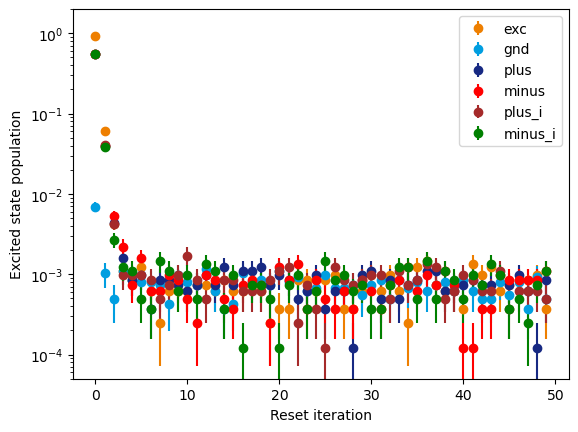

In [588]:
num_rst_ite = np.arange(0,len(res_rst_e))
# plot log of population
plt.figure()

# plot semlogy with error bar
plt.errorbar(num_rst_ite,res_rst_e,yerr=sem_res_rst_e,fmt='o',label='exc',color=orange_color_zi)
plt.errorbar(num_rst_ite,res_rst_g,yerr=sem_res_rst_g,fmt='o',label='gnd',color=blue_color_zi)
plt.errorbar(num_rst_ite,res_rst_plus,yerr=sem_res_rst_plus,fmt='o',label='plus',color=dark_blue_color_zi)
plt.errorbar(num_rst_ite,res_rst_minus,yerr=sem_res_rst_minus,fmt='o',label='minus',color="red")
plt.errorbar(num_rst_ite,res_rst_plus_i,yerr=sem_res_rst_plus_i,fmt='o',label='plus_i',color="brown")
plt.errorbar(num_rst_ite,res_rst_minus_i,yerr=sem_res_rst_minus_i,fmt='o',label='minus_i',color="green")
#plt.semilogy(num_rst_ite,res_rst_e,'-o',label='exc',color=orange_color_zi)
#plt.semilogy(num_rst_ite,res_rst_g,'-o',label='gnd',color=blue_color_zi)
#plt.semilogy(num_rst_ite,res_rst_plus,'-o',label='plus',color=dark_blue_color_zi)
#plt.semilogy(num_rst_ite,res_rst_minus,'-o',label='minus',color="red")
#plt.semilogy(num_rst_ite,res_rst_plus_i,'-o',label='plus_i',color="brown")
#plt.semilogy(num_rst_ite,res_rst_minus_i,'-o',label='minus_i',color="green")

plt.xlabel('Reset iteration')
plt.ylabel('Excited state population')
plt.yscale('log')
plt.ylim(5e-5, 2e0)
plt.legend()

In [469]:
def t1_optimized_kernel(
    qubits,
    drive_pulse,
    integration_kernel,
    readout_pulse,
    delay_sweep,
    num_averages=2**10,
    acquisition_type = AcquisitionType.DISCRIMINATION,
    threshold=0,
):
    exp_t1 = Experiment(
        uid="T1 Exp",
        signals=flatten(
            [
                [
                    ExperimentSignal(
                        f"drive_{qubit.uid}", map_to=qubit.signals["drive"]
                    ),
                    ExperimentSignal(
                        f"measure_{qubit.uid}", map_to=qubit.signals["measure"]
                    ),
                    ExperimentSignal(
                        f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]
                    ),
                ]
                for qubit in qubits
            ]
        ),
    )

    ## define Ramsey experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_t1.acquire_loop_rt(
        uid="t1_shots",
        count=num_averages,
        averaging_mode=AveragingMode.SINGLE_SHOT,
        acquisition_type=acquisition_type,
        repetition_mode=RepetitionMode.AUTO,
    ):
        # inner loop - real time sweep of T1 time delays
        with exp_t1.sweep(
            uid="t1_delay_sweep",
            parameter=delay_sweep,
            alignment=SectionAlignment.RIGHT,
        ):
            for qubit in qubits:
                # play qubit excitation pulse - pulse amplitude is swept
                with exp_t1.section(
                    uid=f"{qubit.uid}_excitation", alignment=SectionAlignment.RIGHT
                ):
                    exp_t1.play(signal=f"drive_{qubit.uid}", pulse=drive_pulse(qubit))
                    exp_t1.delay(signal=f"drive_{qubit.uid}", time=delay_sweep)
                # readout pulse and data acquisition
                # measurement
                with exp_t1.section(
                    uid=f"readout_{qubit.uid}", play_after=f"{qubit.uid}_excitation"
                ):
                    exp_t1.measure(
                        measure_signal=f"measure_{qubit.uid}",
                        measure_pulse=readout_pulse(qubit),
                        handle=f"{qubit.uid}_t1",
                        acquire_signal=f"acquire_{qubit.uid}",
                        integration_kernel=integration_kernel,
                        reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                    )
    cal= Calibration()
    cal[f"acquire_{qubit.uid}"] = SignalCalibration(
        oscillator=Oscillator(frequency=0),
        port_delay=240e-9,
        threshold=threshold,
    )

    exp_t1.set_calibration(cal)

    return exp_t1

In [495]:
t1_meas2 = t1_optimized_kernel(
    qubits=[transmon_list[0]],
    drive_pulse=qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    delay_sweep=delay_sweep,
    num_averages=num_avg_reset,
    threshold=.3 # my_threshold,
)

In [471]:
#delay_sweep=LinearSweepParameter(uid="delay_sweep", start=1e-10, stop=100e-6, count=51)
delay_sweep_cnt = 12
delay_sweep_cnt_lin = 50
time_step = 1.7e-6
stop = (delay_sweep_cnt_lin-1)*time_step
delay_sweep_lin = LinearSweepParameter(start=0, stop=stop, count=delay_sweep_cnt_lin)
delay_sweep_array = time_step * np.fromfunction(lambda i, j: 2**j, (1, delay_sweep_cnt), dtype=float)[0]
delay_sweep = SweepParameter(values = delay_sweep_array)

t1_meas = t1_optimized_kernel(
    qubits=[transmon_list[0]],
    drive_pulse=qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    delay_sweep=delay_sweep,
    num_averages=num_avg_reset,
    threshold=my_threshold,
)

compiled_t1 = session.compile(t1_meas)
session.connect(do_emulation=emulate, reset_devices=True)
t1_res = session.run(compiled_t1)

2023.10.03 16:27:35.773 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.10.03 16:27:35.782 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.10.03 16:27:35.800 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 119
2023.10.03 16:27:35.801 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 4624
2023.10.03 16:27:35.802 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.
2023.10.03 16:27:35.803 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.10.03 16:27:35.805 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.10.03 16:27:35.846 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.10.03 16:27:37.270 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.10.03 16:27:37.412 laboneq.controller.devices.device

In [ ]:
t1_data = np.real(np.transpose(t1_res.get_data("q0_t1")))
t1_mean = [np.mean(i) for i in t1_data]
t1_std = [np.std(i) for i in t1_data]
t1_sem = [i/np.sqrt(num_avg_reset) for i in t1_std]

In [530]:
#t1_res.compiled_experiment.experiment.sections[0].children[0].children[0].children[0].pulse.amplitude = float(t1_res.compiled_experiment.experiment.sections[0].children[0].children[0].children[0].pulse.amplitude)
#t1_res.experiment.sections[0].children[0].children[0].children[0].pulse.amplitude = float(t1_res.experiment.sections[0].children[0].children[0].children[0].pulse.amplitude)

In [464]:
# Create samples for logarithmic post selection of active qubit reset data
log_sampling = np.logspace(0,np.log10(len(plot_delay_lin)-1), 15, endpoint=True)
log_sampling = [int(np.round(i)) for i in log_sampling]
log_sampling

[1, 1, 2, 2, 3, 4, 5, 7, 9, 12, 16, 21, 28, 37, 49]

In [ ]:
res_rst_g=[]
std_res_rst_g=[]

c:\Users\ZI_at_PSI\anaconda3\envs\labone_q_training\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\ZI_at_PSI\anaconda3\envs\labone_q_training\Lib\site-packages\numpy\ma\core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


(0.0001, 1.0)

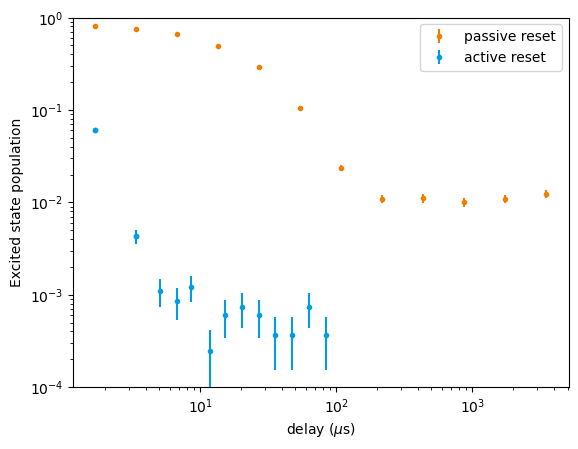

In [564]:


plot_delay_lin=delay_sweep_lin.values[:num_rst]*1e6
plot_delay=delay_sweep.values[:num_rst]*1e6

res_rst_e = np.array(res_rst_e)

plt.figure()
ax = plt.axes()
ax.set_xscale("log")
ax.set_yscale("log")
# plt.plot(plot_delay,np.real(t1_data[:num_rst]),"-o",color=orange_color_zi,label='passive reset')
#plt.plot(plot_delay, t1_mean, ".", color=orange_color_zi)
plt.errorbar(plot_delay, t1_mean, t1_sem,fmt='.',color=orange_color_zi,label='passive reset')
#plt.plot(plot_delay_lin[log_sampling],np.real(res_rst_e[log_sampling]),'.',color=blue_color_zi)
plt.errorbar(plot_delay_lin[log_sampling],np.real(res_rst_e[log_sampling]),np.real(sem_res_rst_e[log_sampling]),fmt='.',color=blue_color_zi,label='active reset')
plt.xlabel("delay ($\mu$s)")
plt.ylabel("Excited state population")
plt.legend()
plt.ylim(1e-4, 1e0)
#plt.axvline(x=t1*1e6, color='gray', linestyle='--', linewidth=2)
#plt.text(x=2*t1*1e6,y= max(y)/2,s=f"T1= {t1*1e6:.3f}us.")

T1 found to be 19.618 us.


1.961840108771843e-05

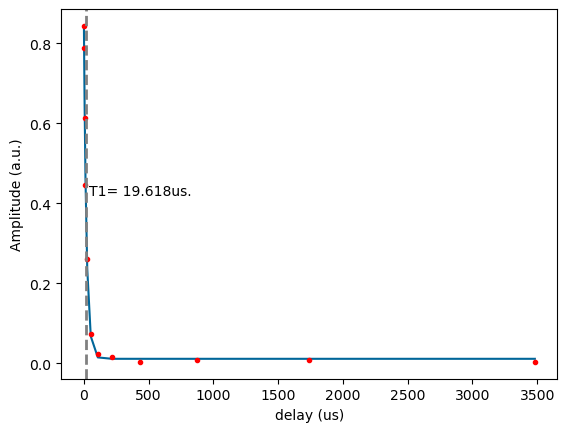

In [388]:
evaluate_T1(t1_res, "q0_t1")
#plt.plot(t1_res.acquired_results["q0_t1"].data.real,'-o')